In [1]:
# Introduction

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import signal

from sklearn.model_selection import train_test_split

## Download the data
http://mindbigdata.com/opendb/index.html

In [2]:
%%bash
# #Uncomment to download the data
# #wget -q http://mindbigdata.com/opendb/MindBigData-IN-v1.06.zip
# wget -q http://mindbigdata.com/opendb/MindBigData-EP-v1.0.zip
# mkdir -p DATA
# unzip -qq MindBigData-EP-v1.0.zip
# mv EP1.01.txt DATA/EP.txt
# rm MindBigData-EP-v1.0.zip

In [3]:
# Load and clean data

In [4]:
PATH_DATA="DATA/EP.txt"

with open(PATH_DATA,'r') as f:
    print(f.readline())

67635	67635	EP	AF3	6	260	4395.384615,4382.564102,4377.435897,4387.179487,4395.897435,4398.461538,4396.923076,4391.794871,4391.282051,4395.897435,4398.974358,4396.410256,4392.820512,4392.820512,4395.384615,4398.974358,4394.358974,4381.538461,4376.410256,4383.589743,4387.179487,4388.717948,4397.948717,4401.538461,4397.948717,4398.974358,4398.974358,4395.897435,4396.923076,4398.461538,4397.948717,4396.410256,4391.794871,4389.743589,4389.743589,4385.641025,4387.692307,4393.846153,4389.743589,4381.025641,4377.948717,4378.461538,4377.435897,4385.128205,4393.333333,4389.230769,4382.564102,4378.974358,4375.384615,4378.461538,4386.153846,4389.230769,4393.846153,4390.256410,4374.871794,4367.692307,4374.871794,4384.615384,4390.769230,4394.358974,4390.769230,4382.051282,4381.025641,4385.641025,4376.923076,4365.641025,4373.333333,4377.948717,4365.128205,4363.589743,4375.897435,4374.358974,4368.205128,4373.333333,4378.461538,4375.897435,4374.358974,4376.410256,4377.435897,4376.410256,4370.256410,437

In [5]:
df=pd.read_csv(PATH_DATA,delimiter="\t",header=None,names=["id","event","device","channel","code","size","data"])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910476 entries, 0 to 910475
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       910476 non-null  int64 
 1   event    910476 non-null  int64 
 2   device   910476 non-null  object
 3   channel  910476 non-null  object
 4   code     910476 non-null  int64 
 5   size     910476 non-null  int64 
 6   data     910476 non-null  object
dtypes: int64(4), object(3)
memory usage: 48.6+ MB
None


,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"4395.384615,4382.564102,4377.435897,4387.17948..."
1,67636,67635,EP,F7,6,260,"4489.230769,4475.384615,4474.358974,4486.66666..."
2,67637,67635,EP,F3,6,260,"4538.461538,4528.717948,4524.615384,4526.15384..."
3,67638,67635,EP,FC5,6,260,"4207.692307,4205.641025,4200.512820,4194.35897..."
4,67639,67635,EP,T7,6,260,"4497.948717,4498.461538,4494.871794,4497.94871..."


In [6]:
df.id.nunique()

910476

In [7]:
df.event.nunique()

65034

In [8]:
df.channel.nunique()

14

<AxesSubplot:>

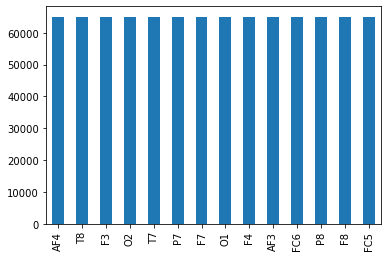

In [9]:
df.channel.value_counts().plot.bar()

In [10]:
df.code.nunique()

11

<AxesSubplot:>

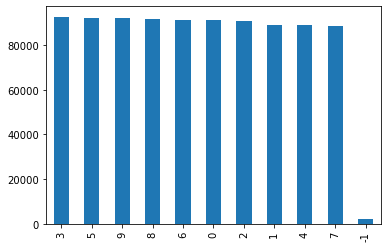

In [11]:
df.code.value_counts().plot.bar()

In [12]:
df=df.query("code!=-1")

In [13]:
df["size"].mean()

259.52050867052026

In [14]:
df["size"].std()

2.3160987941620177

### Dealing with the data values

In [15]:
df.data=df.data.apply(lambda x: [float(i) for i in x.split(",")])

In [16]:
df.data.apply(np.mean).agg(["mean","std"])

mean    4330.338257
std      200.301916
Name: data, dtype: float64

In [17]:
df.data.apply(np.std).agg(["mean","std"])

mean    14.974794
std     29.015235
Name: data, dtype: float64

In [18]:
event_id=67635
df.query(f"event=={event_id}")

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"[4395.384615, 4382.564102, 4377.435897, 4387.1..."
1,67636,67635,EP,F7,6,260,"[4489.230769, 4475.384615, 4474.358974, 4486.6..."
2,67637,67635,EP,F3,6,260,"[4538.461538, 4528.717948, 4524.615384, 4526.1..."
3,67638,67635,EP,FC5,6,260,"[4207.692307, 4205.641025, 4200.51282, 4194.35..."
4,67639,67635,EP,T7,6,260,"[4497.948717, 4498.461538, 4494.871794, 4497.9..."
5,67640,67635,EP,P7,6,260,"[4203.076923, 4192.820512, 4194.871794, 4204.6..."
6,67641,67635,EP,O1,6,260,"[4203.076923, 4193.333333, 4194.871794, 4207.1..."
7,67642,67635,EP,O2,6,260,"[4229.743589, 4216.923076, 4207.179487, 4215.3..."
8,67643,67635,EP,P8,6,260,"[4245.641025, 4236.410256, 4218.461538, 4220.0..."
9,67644,67635,EP,T8,6,260,"[4506.666666, 4501.025641, 4496.923076, 4496.9..."


In [19]:
# generate times column
df["time"]=df.apply(lambda row: list(np.arange(0,2,1/row.size)),axis=1)

In [20]:
def plot_event(event_id):
    df_aux=df.query(f"event=={event_id}")
    df_plot=pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"])))
    plt.figure(figsize=(10,10))
    sns.lineplot(data=df_plot)
    plt.title(f"Event: {df_aux.iloc[0].event} - Digit: {df_aux.iloc[0].code}")

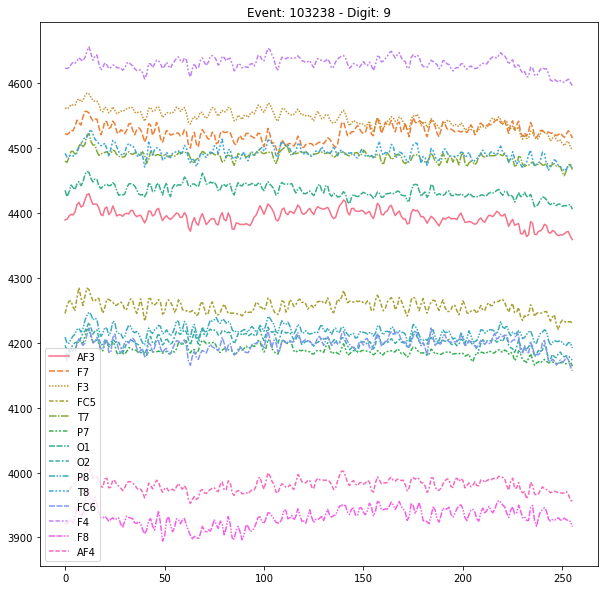

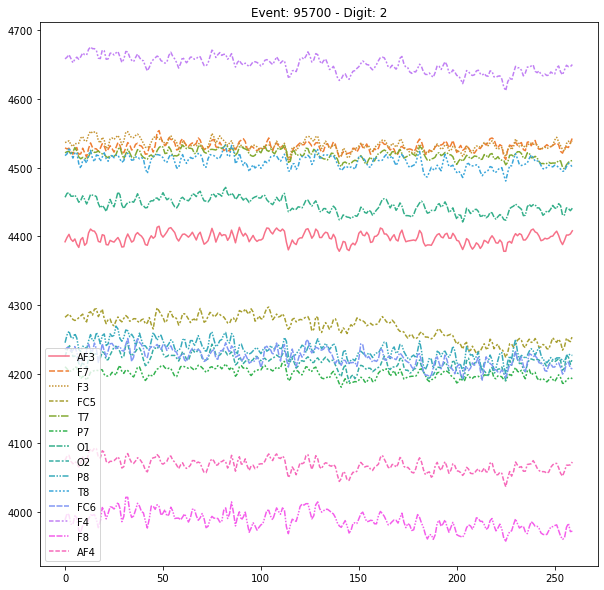

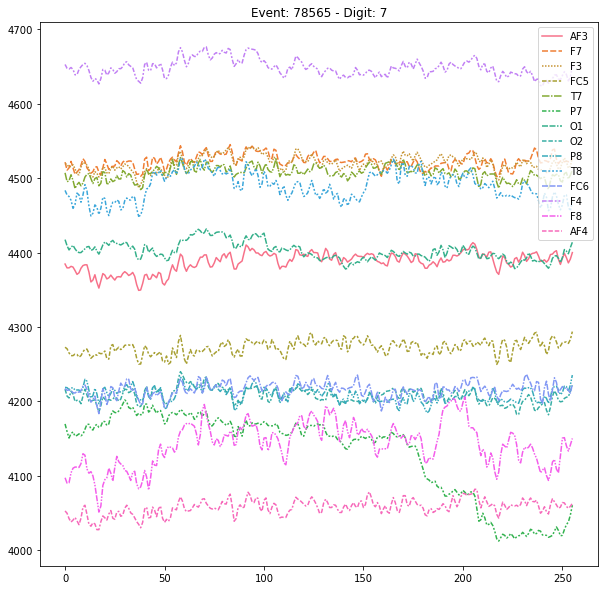

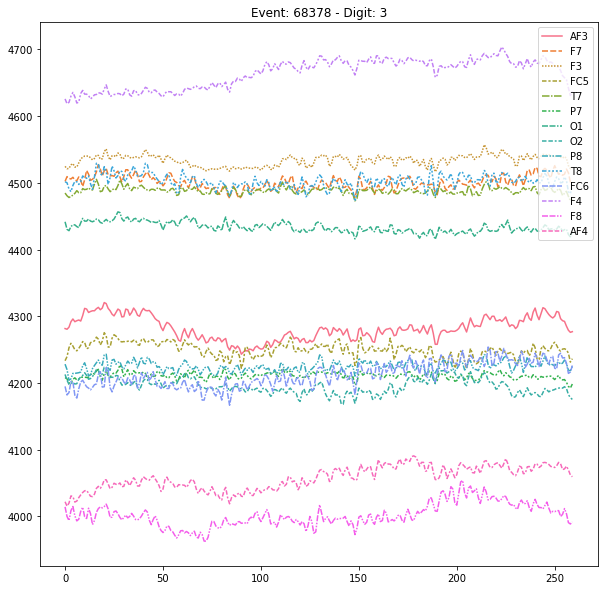

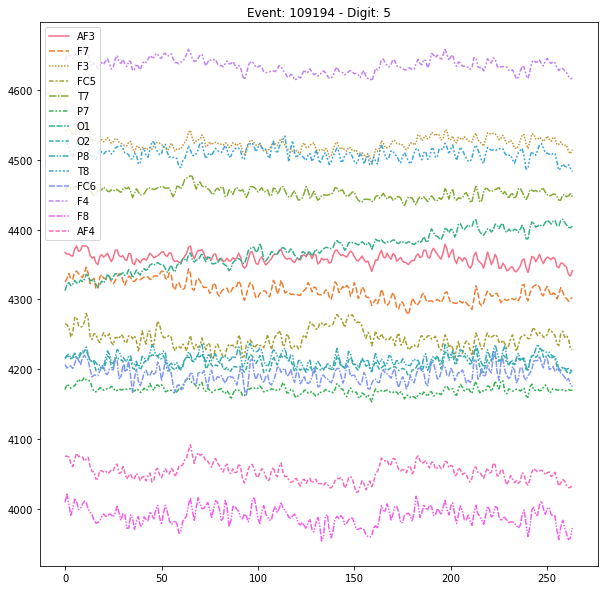

In [21]:
for ev_id in random.sample(df.event.unique().tolist(),5):
    plot_event(ev_id)

## Modeling

In [22]:
def get_sample(event_id):
    df_aux=df.query(f"event=={event_id}")
    return pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"]))).values.T.reshape(1,len(df_aux["channel"]),-1)

In [23]:
get_sample(event_id).shape

(1, 14, 260)

In [27]:
def get_values_df(df_aux,resample_value=260):
    df_aux=df_aux.sort_values(by="channel")
    channels_values=pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"]))).values.T.reshape(len(df_aux["channel"]),-1)
    channels_values=signal.resample(channels_values,resample_value,axis=1)
    label=df_aux.code.iloc[0]
    return pd.Series({'eeg': channels_values, 'label': label}) #https://stackoverflow.com/questions/10751127/returning-multiple-values-from-pandas-apply-on-a-dataframe


In [25]:
df.head()

,id,event,device,channel,code,size,data,time
0,67635,67635,EP,AF3,6,260,"[4395.384615, 4382.564102, 4377.435897, 4387.1...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
1,67636,67635,EP,F7,6,260,"[4489.230769, 4475.384615, 4474.358974, 4486.6...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
2,67637,67635,EP,F3,6,260,"[4538.461538, 4528.717948, 4524.615384, 4526.1...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
3,67638,67635,EP,FC5,6,260,"[4207.692307, 4205.641025, 4200.51282, 4194.35...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
4,67639,67635,EP,T7,6,260,"[4497.948717, 4498.461538, 4494.871794, 4497.9...","[0.0, 0.14285714285714285, 0.2857142857142857,..."


In [28]:
df_preprocessed=df.groupby(['event']).apply(lambda row: get_values_df(row)).reset_index()

In [29]:
## Train test split
ids_train, ids_test, y_train, y_test=train_test_split(df_preprocessed.index,df_preprocessed.label,test_size=0.2,random_state=11)

In [30]:
y_train.value_counts()/sum(y_train.value_counts())

5    0.102100
3    0.101869
2    0.101060
8    0.100829
9    0.100347
6    0.100096
0    0.100039
1    0.098593
7    0.097842
4    0.097225
Name: label, dtype: float64

In [31]:
y_test.value_counts()/sum(y_test.value_counts())

9    0.104432
3    0.102582
6    0.102351
0    0.102042
8    0.101657
4    0.100424
5    0.098035
7    0.097033
2    0.096339
1    0.095106
Name: label, dtype: float64

In [32]:
df_train=df_preprocessed.loc[ids_train].reset_index(drop=True)
df_test=df_preprocessed.loc[ids_test].reset_index(drop=True)

In [33]:
## Normalize data
NORMALIZE=True
if NORMALIZE:
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    scaler = scaler.fit(np.concatenate(df_train.eeg.values, axis=0))

    df_train.eeg=df_train.eeg.apply(scaler.transform)
    df_test.eeg=df_test.eeg.apply(scaler.transform)

In [34]:
df_test.head()

,event,eeg,label
0,116185,"[[0.31790691636320273, 0.2700850804768532, 0.2...",9
1,127306,"[[0.3153828615073148, 0.3432844477727828, 0.32...",5
2,98804,"[[0.3608158095380699, 0.33038523829512334, 0.3...",6
3,104133,"[[0.31538286150731926, 0.3028985913121417, 0.3...",9
4,91286,"[[-0.2626251492376555, -0.2498828312979157, -0...",4


In [35]:
print(df_train.shape)
print(df_test.shape)

(51900, 3)
(12975, 3)


## Dataset class and dataloaders

In [36]:
fs = 260/2
nperseg=260

flatten = lambda t: [item for sublist in t for item in sublist]

def get_periodogram_all(x):
    out=[]
    for i in range(x.shape[0]):
        f, Pxx_den = signal.welch(x[i], fs, nperseg=nperseg)
        out.append(Pxx_den)
    return flatten(out)

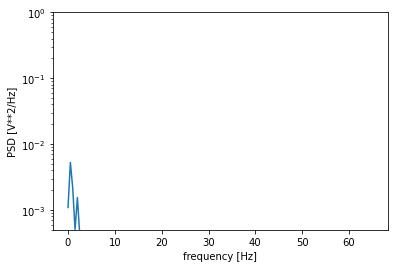

In [38]:
f, Pxx_den = signal.welch(df_train.loc[0].eeg[1], fs, nperseg=nperseg)
plt.semilogy(f, Pxx_den)
plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [39]:
df_train["welch"]=df_train.eeg.apply(get_periodogram_all)
df_test["welch"]=df_test.eeg.apply(get_periodogram_all)

In [40]:
df_train.head()

,event,eeg,label,welch
0,107011,"[[0.37343606905179305, 0.36923180060315464, 0....",4,"[8.774489898887289e-07, 0.00015758738609029078..."
1,98337,"[[0.254805604028875, 0.29027800870718046, 0.26...",3,"[3.845161520107591e-05, 0.0002991176538758099,..."
2,120399,"[[0.23966128965925945, 0.29785035925455655, 0....",7,"[8.051669305512212e-05, 0.00028899425741702155..."
3,121993,"[[0.4895424841407182, 0.5275449203354562, 0.51...",4,"[1.8136857898776708e-05, 0.0008466157119962428..."
4,118369,"[[0.3128588115733264, 0.2953262407647656, 0.30...",7,"[0.0001753244688710504, 0.0021470984665756415,..."


# Model

In [42]:
len(df_train.welch.loc[0])

1834

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

X_train=pd.DataFrame.from_records(df_train["welch"].values)
y_train=np.asarray(df_train["label"])

PCA=False
if PCA:
    pca = PCA(n_components=20)
    pca.fit(X_train)

    print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))

In [49]:
if PCA:
    X_train = pca.transform(X_train)

clf = RandomForestClassifier(n_estimators=500, random_state=0,n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=0)

In [50]:
y_train_pred=clf.predict(X_train)

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5192
           1       1.00      1.00      1.00      5117
           2       1.00      1.00      1.00      5245
           3       1.00      1.00      1.00      5287
           4       1.00      1.00      1.00      5046
           5       1.00      1.00      1.00      5299
           6       1.00      1.00      1.00      5195
           7       1.00      1.00      1.00      5078
           8       1.00      1.00      1.00      5233
           9       1.00      1.00      1.00      5208

    accuracy                           1.00     51900
   macro avg       1.00      1.00      1.00     51900
weighted avg       1.00      1.00      1.00     51900



In [52]:
X_test=pd.DataFrame.from_records(df_test["welch"].values)
y_test=np.asarray(df_test["label"])

if PCA:
    X_test=pca.transform(X_test)

y_test_pred=clf.predict(X_test)

print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.13      0.17      0.14      1324
           1       0.09      0.08      0.09      1234
           2       0.09      0.10      0.09      1250
           3       0.11      0.12      0.11      1331
           4       0.08      0.06      0.07      1303
           5       0.11      0.15      0.12      1272
           6       0.10      0.09      0.10      1328
           7       0.12      0.09      0.10      1259
           8       0.11      0.10      0.10      1319
           9       0.11      0.09      0.10      1355

    accuracy                           0.11     12975
   macro avg       0.10      0.11      0.10     12975
weighted avg       0.10      0.11      0.10     12975



In [42]:
# Hyperparameter tuning

In [ ]:
# Using a random forest to optimize
from skopt import forest_minimize
import xgboost as xgb
from sklearn.model_selection import cross_val_score

def tune_xgbc(params):
    # https://www.kaggle.com/general/17120
    # Implementation learned on a lesson of Mario Filho (Kagle Grandmaster) for parametes optmization.
    # Link to the video: https://www.youtube.com/watch?v=WhnkeasZNHI

    """Function to be passed as scikit-optimize minimizer/maximizer input

    Parameters:
    Tuples with information about the range that the optimizer should use for that parameter, 
    as well as the behaviour that it should follow in that range.

    Returns:
    float: the metric that should be minimized. If the objective is maximization, then the negative 
    of the desired metric must be returned. In this case, the negative AUC average generated by CV is returned.
    """


    #Hyperparameters to be optimized
    print(params)
    learning_rate = params[0] 
    n_estimators = params[1] 
    max_depth = params[2]
    min_child_weight = params[3]
    gamma = params[4]
    subsample = params[5]
    colsample_bytree = params[6]


    #Model to be optimized
    mdl = xgb.XGBClassifier(learning_rate = learning_rate, 
                            n_estimators = n_estimators, 
                            max_depth = max_depth, 
                            min_child_weight = min_child_weight, 
                            gamma = gamma, 
                            subsample = subsample, 
                            colsample_bytree = colsample_bytree,objective = 'multi:softmax', seed = 42,n_jobs=-1)


    #Cross-Validation in order to avoid overfitting
    f1 = cross_val_score(mdl, X_train, y_train, cv = 10, scoring = 'f1_weighted')

    print(f1.mean())
    # as the function is minimization (forest_minimize), we need to use the negative of the desired metric (AUC)
    return -f1.mean()

# Creating a sample space in which the initial randomic search should be performed
space = [(1e-3, 1e-1, 'log-uniform'), # learning rate
          (100, 2000), # n_estimators
          (1, 10), # max_depth 
          (1, 6.), # min_child_weight 
          (0, 0.5), # gamma 
          (0.5, 1.), # subsample 
          (0.5, 1.)] # colsample_bytree 

# Minimization using a random forest with 20 random samples and 50 iterations for Bayesian optimization.
result = forest_minimize(tune_xgbc, space, random_state = 42, n_random_starts = 20, n_calls  = 25, verbose = 1)

Iteration No: 1 started. Evaluating function at random point.
[0.03918194347141743, 1394, 8, 3.9932924209851834, 0.07800932022121827, 0.5779972601681014, 0.5290418060840998]


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:14:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:33:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [ ]:
result